# Traffic Sign Classifier

## Introduction

In this notebook we will first briefly explore the data with some visualisations. Aferwards we define a model architecture and train the model on the available training data. The final model weights are safed and can be used for testing with the REST API.

The approach chosen for this task is a Convolutional Neural Network (CNN) and we will be using the TensorFlow framework for training and inference. 

---

## Dataset Exploration

Visualize the German Traffic Signs Dataset. The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [5]:
# Load pickled data
import pickle

training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
## Extract some statistics and output:
n_train = X.shape[0]
n_test = X_test.shape[0]
image_shape = X[0].shape
n_classes = len(set(y))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [7]:
## Import dependencies
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.utils import shuffle
import csv


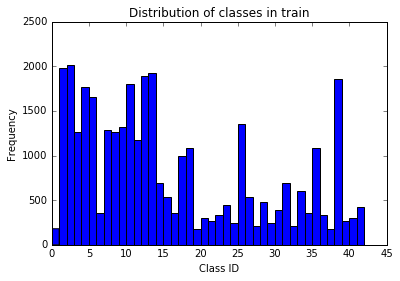

In [8]:
## Data exploration visualization

plt.hist(y, bins=n_classes-1)
plt.title("Distribution of classes in train")
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.show()

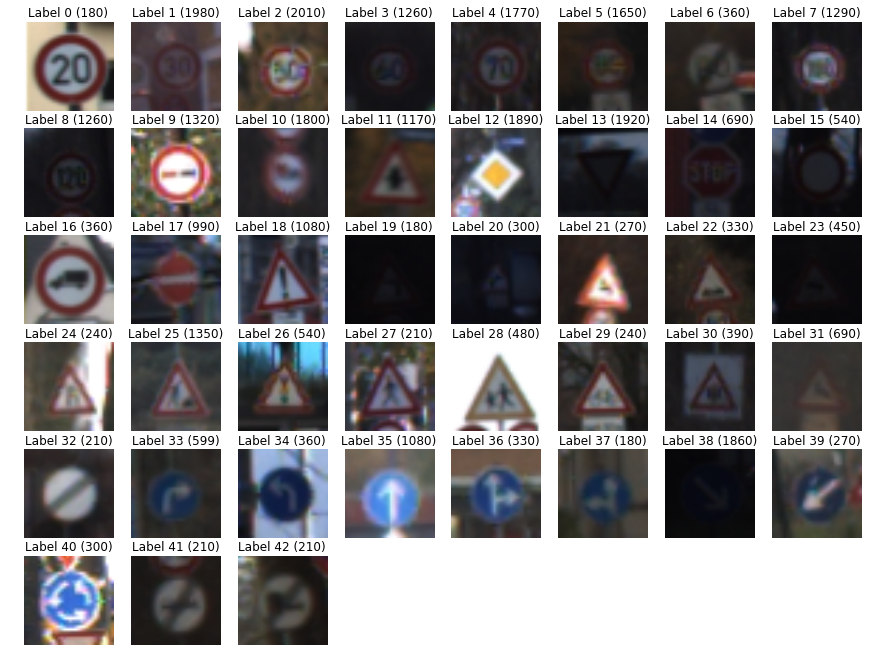

In [9]:
# Plot first image of each label
def example_of_labels(images, labels):
    """
    Extract first image of each label.
    *param images: List of images
    *param labels: Array of labels
    *output: First image of each label with count of occurences per label 
    """
    unique_labels = set(y)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        image = images[labels.tolist().index(label)]
        plt.subplot(8, 8, i)
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.tolist().count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

example_of_labels(X, y)

---

## Image Augmentation

To make our model more robust, we will apply random augmentations on the training images. 

In [10]:
def normalize_grayscale(image):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    *param image: The image data to be normalized
    *return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

def grayscale(image):
    """
    Applies the Grayscale transform from cv2
    *param image: The image data to be converted to grayscale
    *return: Grayscale image data
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def rotate_image(image, rotate=20):
    """
    Rotate input image by randomly rotate with
    *param image: The image data to be rotated
    *param rotate: maximum absolute ration that can be applied to image in degrees
    *return: Rotated image data
    """
    
    # Extract width and height of image
    width, height, _ = image.shape

    # Add random rotation to image
    rand_rotation = np.random.uniform(low=-rotate, high=rotate)
    M = cv2.getRotationMatrix2D((width/2, height/2), rand_rotation, 1)
    return(cv2.warpAffine(image, M, (width, height)))

def adjust_brightness(image, brightness=60):
    """
    Adjust brightness of input image with random value
    *param image: The image data that will be adjusted with brightness
    *param brightness: maximum value change that can to be added to all pixels
    *return: Image data with adjusted brightness
    """
    rand_brightness = np.random.uniform(low=-brightness, high=brightness)
    return(cv2.add(image, rand_brightness))

def adjust_contrast(image, contrast=[1, 2]):
    """
    Adjust brightness of input image with random value
    *param image: The image data that will be adjusted with brightness
    *param brightness: maximum value change that can to be added to all pixels
    *return: Image data with adjusted brightness
    """
    rand_contrast = np.random.uniform(low=contrast[0], high=contrast[1])
    return(cv2.multiply(image, rand_contrast))

def scale_image(image, scale=[0.6, 1.4]):
    """
    Adjust brightness of input image with random value
    *param image: The image data that will be adjusted with brightness
    *param brightness: maximum value change that can to be added to all pixels
    *return: Scaled image data
    """
    
    # Extract width and height of image
    width, height, _ = image.shape    
    
    scale_x = np.random.uniform(low=scale[0], high=scale[1])
    scale_y = np.random.uniform(low=scale[0], high=scale[1])
    scale_matrix = np.array([[scale_x, 0., (1. - scale_x) * width / 2.], 
                             [0., scale_y, (1. - scale_y) * height / 2.]], 
                            dtype=np.float32)
    return(cv2.warpAffine(image, scale_matrix, (width, height), flags=cv2.INTER_LINEAR, 
                         borderMode=cv2.BORDER_REFLECT_101))

def transform_image(image):
    """
    Transform input image by randomly adjusting brightness, add contrast, and rotation
    *param image: The image data to be transformed
    *return: Transformed image data
    """
    return(adjust_brightness(rotate_image(scale_image(image))))


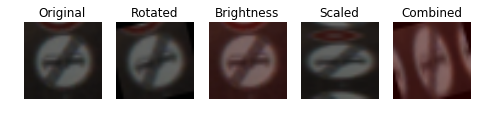

In [14]:
## Plot some transformations on images
plt.show()
plt.figure(figsize=(8, 8))

image = X[20]

plt.subplot(1, 5, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image)
plt.subplot(1, 5, 2)
plt.axis('off')
plt.title("Rotated")
plt.imshow(rotate_image(image, 20))
plt.subplot(1, 5, 3)
plt.axis('off')
plt.title("Brightness")
plt.imshow(adjust_brightness(image, 60))
plt.subplot(1, 5, 4)
plt.axis('off')
plt.title("Scaled")
plt.imshow(scale_image(image))
plt.subplot(1, 5, 5)
plt.axis('off')
plt.title("Combined")
plt.imshow(transform_image(image))

plt.show()


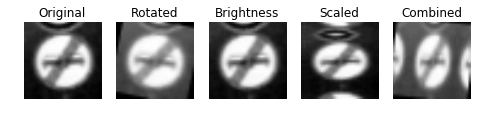

In [13]:
# Plot transformations on images in grayscale
# Note: because the transformations are random they should not be an exact grayscale replica of the examples above
plt.show()
plt.figure(figsize=(8, 8))

image = X[20]

plt.subplot(1, 5, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(grayscale(image), cmap='Greys_r')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.title("Rotated")
plt.imshow(grayscale(rotate_image(image, 20)), cmap='Greys_r')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.title("Brightness")
plt.imshow(grayscale(adjust_brightness(image, 60)), cmap='Greys_r')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.title("Scaled")
plt.imshow(grayscale(scale_image(image)), cmap='Greys_r')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.title("Combined")
plt.imshow(grayscale(transform_image(image)), cmap='Greys_r')

plt.show()


----

## Design and Test Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. 

In [17]:
### Prepare datasets for training-validation and training-testing

# Split training data in training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Also create training set for final predictions on test set
X_full, y_full = shuffle(X, y, random_state=2016)

In [18]:
# Add 5 randomly transformed versions of each image to X_train
X_train_transformed = [[
                        image,
                        transform_image(image),
                        transform_image(image),
                        transform_image(image),
                        transform_image(image),
                        transform_image(image)
                    ] for image in X_train]
X_train_transformed = [item for sublist in X_train_transformed for item in sublist]

# Add copies of the labels
y_train = [val for val in y_train for _ in range(6)]

In [19]:
# Add 5 randomly transformed versions of each image to X
X_transformed = [[
                    image,
                    transform_image(image),
                    transform_image(image),
                    transform_image(image),
                    transform_image(image),
                    transform_image(image)
                ] for image in X_full]
X_transformed = [item for sublist in X_transformed for item in sublist]

# Add copies of the labels
y_full = [val for val in y_full for _ in range(6)]

In [20]:
# Flatten the list of images
X_train = [normalize_grayscale(grayscale(image)).flatten() for image in X_train_transformed]
X_val = [normalize_grayscale(grayscale(image)).flatten() for image in X_val]
X_full = [normalize_grayscale(grayscale(image)).flatten() for image in X_transformed]
X_test = [normalize_grayscale(grayscale(image)).flatten() for image in X_test]

In [21]:
# One-hot-encode the labels
encoder = LabelBinarizer()
encoder.fit(y)
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)
labels = encoder.transform(y_full)

In [23]:
print("Number of training examples =", len(X))
print("Number of training examples in validation step =", len(X_train))
print("Number of valiation examples in validation step =", len(X_val))
print("Number of test examples =", len(X_val))
print("Shape of a single input =", len(X[0].shape))
print("Shape of a single label =", len(train_labels[0]))

Number of training examples = 34799
Number of training examples in validation step = 187914
Number of valiation examples in validation step = 3480
Number of test examples = 3480
Shape of a single input = 3
Shape of a single label = 43


In [24]:
## Define functions for our model

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [25]:
# Specify model
x = tf.placeholder(tf.float32, shape=[None, 32*32])
y_ = tf.placeholder(tf.float32, shape=[None, 43])
W = tf.Variable(tf.zeros([32*32,43]))
b = tf.Variable(tf.zeros([43]))

# Layer 1: convolutional block
W_conv1 = weight_variable([7, 7, 1, 100])
b_conv1 = bias_variable([100])
x_image = tf.reshape(x, [-1,32,32,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Layer 2: convolutional block
W_conv2 = weight_variable([4, 4, 100, 150])
b_conv2 = bias_variable([150])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Layer 3: convolutional block
W_conv3 = weight_variable([4, 4, 150, 250])
b_conv3 = bias_variable([250])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Layer 4: fully connected
W_fc1 = weight_variable([4 * 4 * 250, 300])
b_fc1 = bias_variable([300])
h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*250])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Layer 5: fully connected
W_fc2 = weight_variable([300, 43])
b_fc2 = bias_variable([43])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [26]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [36]:
batch_size = 512

# Measurements use for graphing loss and accuracy
log_batch_step = 500

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions_prob = tf.nn.softmax(y_conv)
prediction = tf.argmax(y_conv, 1)

In [37]:
epochs = 55

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

init = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train)/batch_size))
    for i in range(epochs):
    #     batch = tf.train.next_batch(50)

        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(i+1, epochs), unit='batches')
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [train_step, accuracy], 
                feed_dict={x: batch_features, y_: batch_labels, keep_prob:0.5})
                        
            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate training and validation accuracy
                training_accuracy = accuracy.eval(feed_dict={
                        x: batch_features, y_: batch_labels, keep_prob: 1.0})
                validation_accuracy = accuracy.eval(feed_dict={
                        x: X_val, y_: val_labels, keep_prob: 1.0})

                # Log results
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        if i%5 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                    x: batch_features, y_: batch_labels, keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
            val_accuracy = accuracy.eval(feed_dict={
                    x: X_val, y_: val_labels, keep_prob: 1.0})
            print("step %d, validation accuracy %g"%(i, val_accuracy))
            
    # Save model for later use
    save_path = saver.save(session, "./model/model_val.ckpt")
    print("Model saved in file: %s" % save_path)
    
    print('Training accuracy at {}'.format(training_accuracy))
    print('Validation accuracy at {}'.format(validation_accuracy))


Instructions for updating:
Use `tf.global_variables_initializer` instead.



Epoch  2/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 0, training accuracy 0.3
step 0, validation accuracy 0.122701


Epoch  7/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 5, training accuracy 1
step 5, validation accuracy 0.430747


Epoch 12/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 10, training accuracy 1
step 10, validation accuracy 0.69569


Epoch 17/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 15, training accuracy 1
step 15, validation accuracy 0.827874


Epoch 22/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 20, training accuracy 1
step 20, validation accuracy 0.902874


Epoch 27/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 25, training accuracy 1
step 25, validation accuracy 0.928448


Epoch 32/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 30, training accuracy 1
step 30, validation accuracy 0.946552


Epoch 37/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 35, training accuracy 1
step 35, validation accuracy 0.964943


Epoch 42/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 40, training accuracy 1
step 40, validation accuracy 0.962356


Epoch 47/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 45, training accuracy 1
step 45, validation accuracy 0.968104


Epoch 52/55:   0%|          | 0/368 [00:00<?, ?batches/s]

step 50, training accuracy 1
step 50, validation accuracy 0.96954


Epoch 55/55: 100%|██████████| 368/368 [00:26<00:00, 13.85batches/s]


Model saved in file: /tmp/model_val.ckpt
Training accuracy at 0.962890625
Validation accuracy at 0.9778736233711243


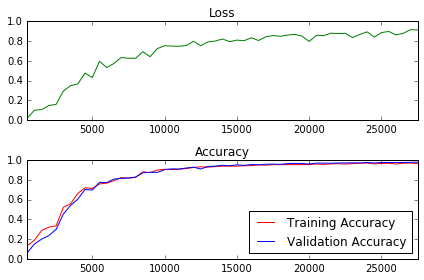

In [38]:
# Plot loss during training
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
# Plot training and validation accuracy across batches
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [40]:
# Load class names
with open('./data/signnames.csv', 'r') as f:
    creader = csv.reader(f)
    names = list(creader)
    class_names = [a[1] for a in names[1:]]

In [43]:
# Extract probabilities and predictions on validation set
def eval_model_on_dataset(data, labels, ckpt_file):
    with tf.Session() as sess:
        # Restore model checkpoint. 
        saver.restore(sess, ckpt_file)
        for i in range(1):
            # Run model on every image of the dataset.
            probabilities = predictions_prob.eval(feed_dict={x: data, y_: labels, keep_prob: 1.0})
            y_hat = prediction.eval(feed_dict={x: data, y_: labels, keep_prob: 1.0})
            correct = correct_prediction.eval(feed_dict={x: data, y_: labels, keep_prob: 1.0})
    return probabilities, y_hat, correct


test_probabilities, test_predictions, correct = eval_model_on_dataset(X_val, val_labels, '/tmp/model_val.ckpt')

INFO:tensorflow:Restoring parameters from /tmp/model_val.ckpt


In [49]:
# Extract incorrect predictions indices
incorrect = [i for i in range(0,len(correct)) if correct[i] == False]
print(len(incorrect))

74


In [45]:
# Load validation data for plotting
_, X_val_plot, _, y_val_plot = cross_validation.train_test_split(X, y, 
                                                                       test_size=0.1, random_state=42)

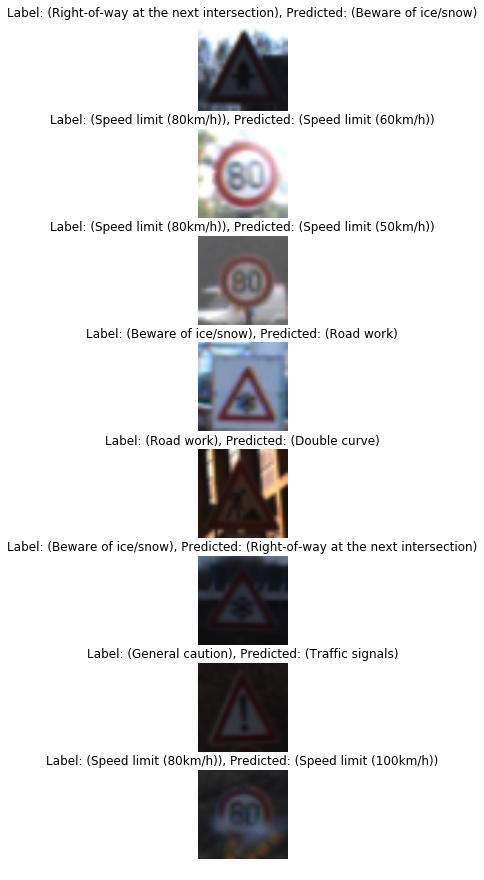

In [54]:
# Plot images of 8 incorrect predicted labels
def plot_incorrect_images(images, labels, predicted, indices):
    plt.figure(figsize=(15, 15))
    i = 1
    for index in incorrect[:8]:
        image = images[index]
        plt.subplot(8, 1, i)
        plt.axis('off')
        plt.title("Label: ({0}), Predicted: ({1})".format(class_names[labels[index]], class_names[predicted[index]]))
        i += 1
        _ = plt.imshow(image)
    plt.show()

plot_incorrect_images(X_val_plot, y_val_plot, test_predictions, incorrect)

In [55]:
# Train on the full training data and predict test
# Duplicate of train-validation model with less epochs

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# We decrease the number of epochs with 10% because we have 10% more data.
# We expect our model to learn in less epochs becaue of the equal distribution of the data.
epochs = 50

init = tf.initialize_all_variables()

# session.run(tf.initialize_all_variables())
with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_full)/batch_size))
    for i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_full[batch_start:batch_start + batch_size]
            batch_labels = labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [train_step, accuracy], 
                feed_dict={x: batch_features, y_: batch_labels, keep_prob:0.5})
            
    # Save model for later use
    save_path = saver.save(session, "./model/model.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch 50/50: 100%|██████████| 408/408 [00:29<00:00, 14.20batches/s]


Model saved in file: ./model/model.ckpt


In [56]:
# Predictions on test set
# Check how our model is scoring on the test set

with tf.Session() as session:
    # Restore model from disk
    saver.restore(session, "./model/model.ckpt")
    print("Model restored.")    
    print("test accuracy %g"%accuracy.eval(feed_dict={
                x: X_test, y_: test_labels, keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Model restored.
test accuracy 0.927475


---

## Discussion

In this notebook we have successfully trained and validated a deep learning model to classify traffic signs. This 

- *Cropped images*. the complete training dataset consists out of cropped images. In real world datasets this won't be the case. We can see that our model predicts the type of traffic sign with less accuracy on other (types) of images.
- *Localisation*. A harder task is to localise the traffic signs. 
- *Inference time*. We've chosen to work with a relatively shallow model, to optimise for inference time. While the model performs well on a powerful GPU it is not able to infer predictions in real-time on a smaller GPU.